In [55]:
import os

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

In [56]:
CSV_LOCATION = "peace_sys.csv"

In [57]:
SEED = 0

In [58]:
df = pd.read_csv(CSV_LOCATION)

In [59]:
VARS = {'ID1.1Over' : 'Overarching Identity', 'Int2.4Hist' : 'Interconnected Historically', 
        'Int2.2Econ' : 'Interconnected Economically', 'Dep3.3Econ' : 'Interdependent Economically', 
        'Dep3.2Ecol' : 'Interdependent Ecologically', 'NWNorm5.1': 'Non-Warring Norms', 
        'NWVal4.1' : 'Non-Warring Values', 'SymP6': 'Peace Symbols', 'RitP6' : 'Peace Rituals', 
        'CM8.5Peace' : 'Peaceful Conflict Management Overall'}

In [60]:
y = df['PSysRec']

In [61]:
X = df[VARS.keys()].replace(9, np.nan)
X = X.fillna(X.mean())

In [62]:
X.head(5)

,ID1.1Over,Int2.4Hist,Int2.2Econ,Dep3.3Econ,Dep3.2Ecol,NWNorm5.1,NWVal4.1,SymP6,RitP6,CM8.5Peace
0,2.532258,2.913043,2.984375,2.689655,2.5,3.083333,3.171875,2.923077,2.565217,3.1
1,1.000000,2.913043,1.000000,3.000000,2.5,3.083333,4.000000,2.000000,2.000000,3.1
2,2.532258,2.913043,2.984375,1.000000,1.0,3.083333,2.500000,2.923077,2.565217,3.1
3,2.532258,2.913043,3.000000,3.000000,3.0,3.083333,3.000000,2.923077,2.565217,3.1
4,2.532258,4.000000,4.000000,3.000000,2.0,3.083333,3.000000,3.000000,2.565217,3.1


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.55, random_state=SEED)

In [64]:
param_grid = {'max_iter' : [100, 150, 200, 250, 300], 'C': [0.001,.009,0.01,.09,1,5,10,25]}

In [65]:
logreg = LogisticRegression()

In [66]:
grid_clf = GridSearchCV(logreg, param_grid=param_grid, scoring='f1',)

In [67]:
grid_clf_acc = grid_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [68]:
y_pred_acc = grid_clf_acc.predict(X_test)

In [69]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

Accuracy Score : 0.8846153846153846
Precision Score : 1.0
Recall Score : 0.6666666666666666
F1 Score : 0.8


In [70]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_acc)))

Confusion Matrix : 
[[17  0]
 [ 3  6]]


In [71]:
grid_clf.best_params_

{'C': 1, 'max_iter': 100}

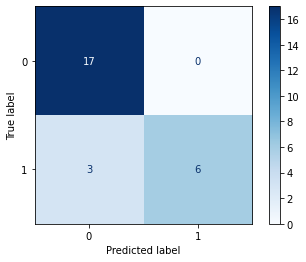

In [82]:
disp = plot_confusion_matrix(grid_clf, X_test, y_test, cmap=plt.cm.Blues)

In [79]:
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>